In [1]:
import scanpy as sc

In [2]:
# Inferring pseudotime for adult human bone marrow
adata = sc.read(
    filename='bone_marrow.h5ad',
    # backup_url="https://figshare.com/ndownloader/files/35826944",
)
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [3]:
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=10)

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/umap/distances.py:1086: 

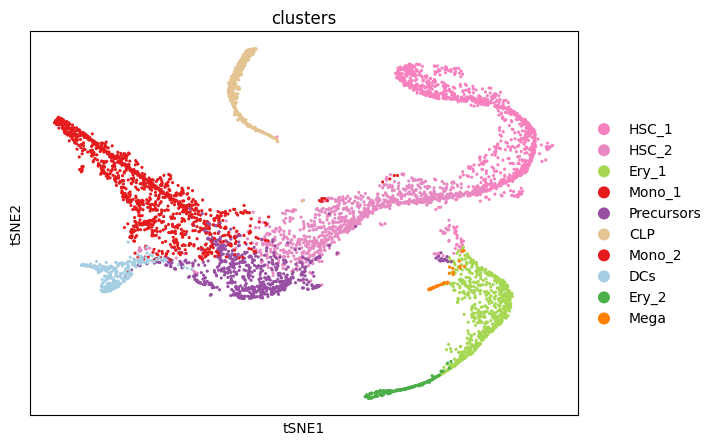

In [4]:
sc.pl.scatter(adata, basis="tsne", color="clusters")

#  Pseudotime construction

In [5]:
# To calculate diffusion pseudotime (DPT), first, the corresponding diffusion maps need to be calculated.
sc.tl.diffmap(adata)

The differentiation hierarchy in bone marrow is well understood. However, it is only know that the developmental process starts in the form of hematopoietic stem cells but not at which cell exactly in the corresponding cluster in our dataset. To identify a putative initial cell, we study the individual diffusion components. We identify the stem cell with the most extreme diffusion component in one dimension (in our case dimension 3).

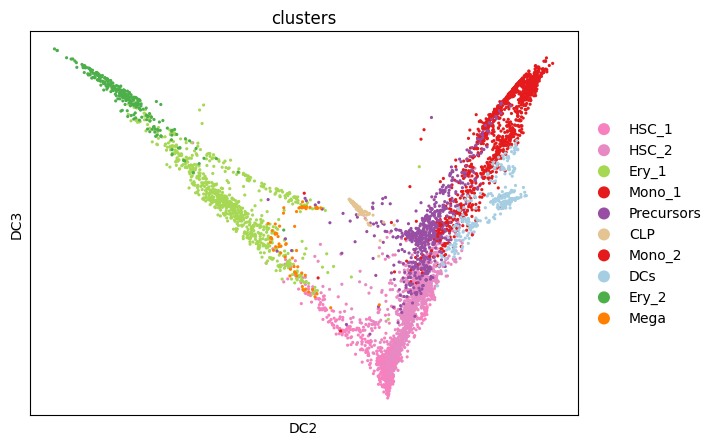

In [6]:
# Setting root cell as described above
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["clusters"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs

In [11]:
sc.tl.dpt(adata)

Different pseudotime methods give different results. Sometimes, one pseudotime captures the underlying developmental processes more accurately. Here, we compare the just computed DPT with the pre-computed Palantir pseudotime (see [here](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) for the corresponding tutorial). One option to compare different pseudotimes is by coloring the low dimensional embedding of the data (here, t-SNE). Here, DPT is extremly high in the cluster of CLPs compared to all other cell types. Contrastingly, the Palantir pseudotime increases continuously with developmental maturity.

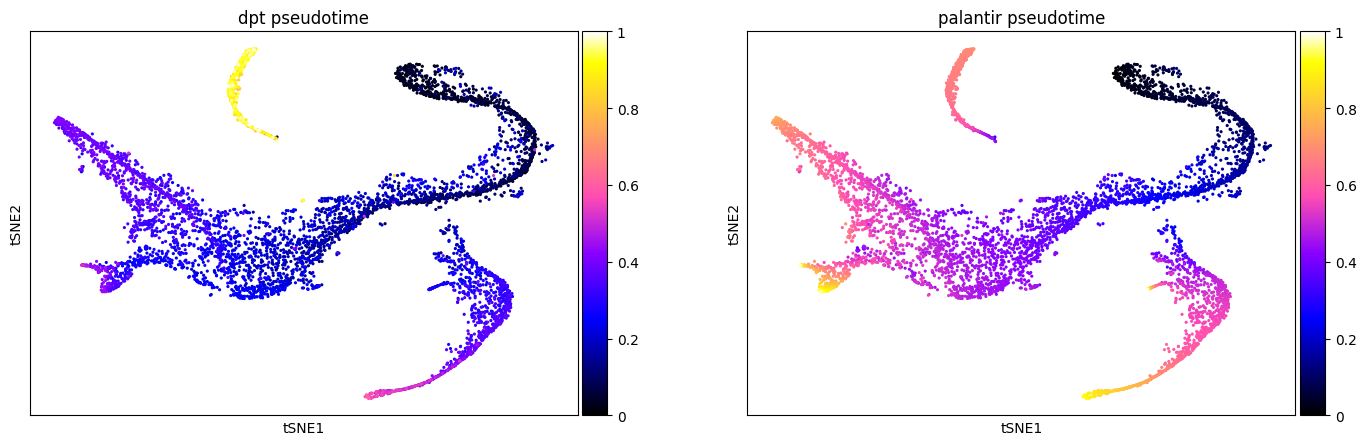

In [12]:
sc.pl.scatter(
    adata,
    basis="tsne",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

Instead of coloring the lower dimensional representation of the data, we can study the distribution of pseudotime values assigned to each cell type cluster. This representation again shows that the CLP cluster forms an outlier in case of DPT. Additionally, clusters such as HSC_1 and HSC_2 include several cells with increased pseudotime. These inflated values contrast our prior biological knowledge that these clusters form the beginning of the developmental process.

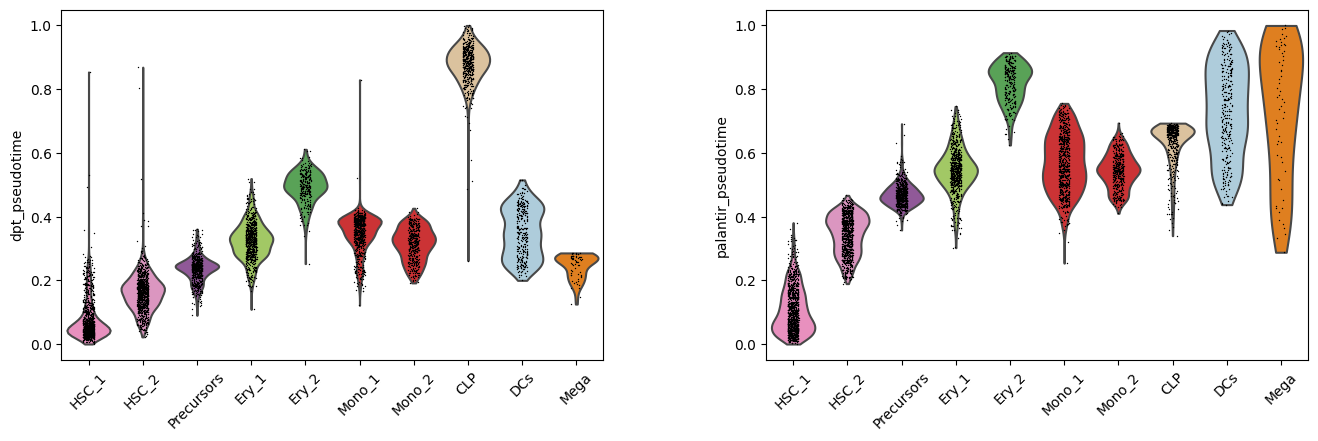

In [13]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="clusters",
    rotation=45,
    order=[
        "HSC_1",
        "HSC_2",
        "Precursors",
        "Ery_1",
        "Ery_2",
        "Mono_1",
        "Mono_2",
        "CLP",
        "DCs",
        "Mega",
    ],
)

Considering these observations and prior knowledge about the development in bone marrow, we would conclude to continue working with the Palantir pseudotime.

Read Later:
 - https://github.com/dpeerlab/Palantir/tree/master